# **Lista 4 de Processamento de Imagens**

Professora: Mylene Farias

Aluna: Daniele Dias

matrícula: 20/0081691

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
# Check current working directory.
print(os.getcwd())
os.chdir('/content/drive/MyDrive/processamento_imagens/Lista 04 ')
# Check current working directory.
print(os.getcwd())

Mounted at /content/drive
/content
/content/drive/MyDrive/processamento_imagens/Lista 04 


# Global

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import itertools
import math


################################################################################
############################## my functions  ###################################
################################################################################

################################ item 1 ########################################
def connected_components(image):
  count, labels = cv2.connectedComponents(image)
  label_hue = np.uint8(179 * labels / np.max(labels))
  blank_channel = 255 * np.ones_like(label_hue)
  labeled_image = cv2.merge([label_hue, blank_channel, blank_channel])
  labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_HSV2BGR)
  labeled_image[label_hue == 0] = 0
  return labeled_image, count, labels

def EulerNumbers(L):
    '''
    For a label matrix L containing nonnegative integers, returns a vector e
    such that e[k-1] is the 4-connected Euler number of the binary image (L ==
    k), from k = 1 to max(L).

    Adapted from:
    https://blogs.mathworks.com/steve/2014/10/02/lots-and-lots-of-euler-numbers/
    Accessed on 1.5.2020.
    '''
    Lp = np.pad(L, ((1,0), (1,0)), 'constant')

    I_NW = Lp[ :-1,  :-1];
    I_N  = Lp[ :-1, 1:  ];
    I_W  = Lp[1:  ,  :-1];

    is_upstream_convexity = np.logical_and(L,(L != I_N));
    is_upstream_convexity = np.logical_and(is_upstream_convexity, (L != I_NW));
    is_upstream_convexity = np.logical_and(is_upstream_convexity,  (L != I_W));

    is_upstream_concavity = np.logical_and(L,(L != I_NW));
    is_upstream_concavity = np.logical_and(is_upstream_concavity, (L == I_N));
    is_upstream_concavity = np.logical_and(is_upstream_concavity, (L == I_W));

    upstream_convexity_labels = L[is_upstream_convexity];
    upstream_concavity_labels = L[is_upstream_concavity];

    total_upstream_convexities = np.bincount(upstream_convexity_labels)[1:] #Discard the zero bin, which is the background.
    total_upstream_concavities = np.bincount(upstream_concavity_labels)[1:]

    return total_upstream_convexities - total_upstream_concavities;

def dilate_erode(image,n):
  kernel = np.ones((n,n), np.uint8)
  img_dilation = cv2.dilate(image, kernel, iterations=1)
  img_erode = cv2.erode(img_dilation,kernel, iterations=1)
  img_erode = cv2.medianBlur(img_erode, 7)
  return img_erode

def circles(image,n):
  img = cv2.medianBlur(image,11)
  img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n, n)))
  cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

  circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=0)

  circles = np.uint16(np.around(circles))
  for i in circles[0,:]:
      # draw the outer circle
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
      # draw the center of the circle
      cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
  return cimg, circles

################################ item 2 ########################################

def erode(image, n):
  element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n,n))
  element_size = element.shape[0]
  rows,columns = image.shape

  border = element_size//2
  # Create a padded image with zeros padding
  padded_image = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_CONSTANT, value = 1)
  for i in range(border, rows+border):
    for j in range(border, columns+border):
      if not image[i-border,j-border]:
        padded_image[ i - border : (i + border)+1, j - border : (j + border)+1] = \
                cv2.bitwise_and(padded_image[ i - border : (i + border)+1, j - border : (j + border)+1],element)

  eroded_image = padded_image[border:border+rows, border:border+columns]
  return eroded_image

def dilate(image, n):
  element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n,n))
  element_size = element.shape[0]
  rows,columns = image.shape

  border = element_size//2
  # Create a padded image with zeros padding
  padded_image = cv2.copyMakeBorder(image, border, border, border, border, cv2.BORDER_CONSTANT, value = 1)
  for i in range(border, rows+border):
    for j in range(border, columns+border):
      if image[i-border,j-border]:
        padded_image[ i - border : (i + border)+1, j - border : (j + border)+1] = \
                cv2.bitwise_or(padded_image[ i - border : (i + border)+1, j - border : (j + border)+1],~element)

  dilated_image = padded_image[border:border+rows, border:border+columns]
  return dilated_image

def thinning(image, n):
  img = ((image / 255).round() * 255).astype(np.uint8)
  skel = np.zeros(img.shape,np.uint8)
  size = np.size(img)

  done = False
  while( not done):
    eroded = erode(img,n)
    temp = dilate(eroded,n)
    temp = (img.astype(int) - temp.astype(int)).astype(np.uint8)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    zeros = size - cv2.countNonZero(img)
    if zeros == size:
        done = True
 
  rows, columns = skel.shape
  label_image = np.ones(skel.shape)
  # Label image
  label = 0
  for i in range(rows):
    for j in range(columns - 1):
      if not skel[i, j]:
        continue
      if i and j and skel[i - 1, j - 1] and not skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j - 1]
      elif i and skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j]
      elif j and skel[i, j - 1]:
        label_image[i, j] = label_image[i, j - 1]
      elif i and j and skel[i - 1, j + 1] and not skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j + 1]
      else:
        label_image[i, j] = label
        label += 1  
  label_hue = np.uint8(179 * label_image / np.max(label_image))
  blank_channel = 255 * np.ones_like(label_hue)
  labeled_image = cv2.merge([label_hue, blank_channel, blank_channel])
  labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_HSV2BGR)
  labeled_image[label_hue == 0] = 0
  labeled_image[label_hue == 1] = 0
  labeled_image[label_hue == 2] = 0
  labeled_image[label_hue == 4] = 0
  return labeled_image

def thinning_native_functions(image, n):
  img = ((image / 255).round() * 255).astype(np.uint8)
  skel = np.zeros(img.shape,np.uint8)
  size = np.size(img)
  element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (n,n))

  done = False
  while( not done):
    eroded = cv2.erode(img, element)
    temp = cv2.dilate(eroded, element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    zeros = size - cv2.countNonZero(img)
    if zeros == size:
        done = True
 
  #count, labels = cv2.connectedComponents(skel)
  rows, columns = skel.shape
  label_image = np.ones(skel.shape)
  # Label image
  label = 0
  for i in range(rows):
    for j in range(columns - 1):
      if not skel[i, j]:
        continue
      if i and j and skel[i - 1, j - 1] and not skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j - 1]
      elif i and skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j]
      elif j and skel[i, j - 1]:
        label_image[i, j] = label_image[i, j - 1]
      elif i and j and skel[i - 1, j + 1] and not skel[i - 1, j]:
        label_image[i, j] = label_image[i - 1, j + 1]
      else:
        label_image[i, j] = label
        label += 1  
  label_hue = np.uint8(179 * label_image / np.max(label_image))
  blank_channel = 255 * np.ones_like(label_hue)
  labeled_image = cv2.merge([label_hue, blank_channel, blank_channel])
  labeled_image = cv2.cvtColor(labeled_image, cv2.COLOR_HSV2BGR)
  labeled_image[label_hue == 0] = 0
  labeled_image[label_hue == 1] = 0
  labeled_image[label_hue == 2] = 0
  labeled_image[label_hue == 4] = 0
  return labeled_image

################################ item 3 ########################################

def k_means(image, K):
  features = image.reshape((-1,3))
  # convert to np.float32
  features = np.float32(features)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  ret,label,center=cv2.kmeans(features,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  temp = center[label.flatten()]
  image_out = temp.reshape((image.shape))
  return image_out

def k_means_each_channel(image, K):
  image_out = np.zeros((image.shape), np.uint8)
  for i in range(image.shape[2]):
    img = image[:,:,i]
    features = img.ravel()
    # convert to np.float32
    features = np.float32(features)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(features,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    temp = center[label.flatten()]
    image_out[:,:,i] = temp.reshape((img.shape))
  return image_out

def calculate_psnr(img1, img2):
  # img1 and img2 have range [0, 255]
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  mse = np.mean((img1 - img2)**2)
  if mse == 0:
    return float('inf')
  return 20 * math.log10(255.0 / math.sqrt(mse))

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc82161d390>,
 Text(0.5, 1.0, 'Fork'))

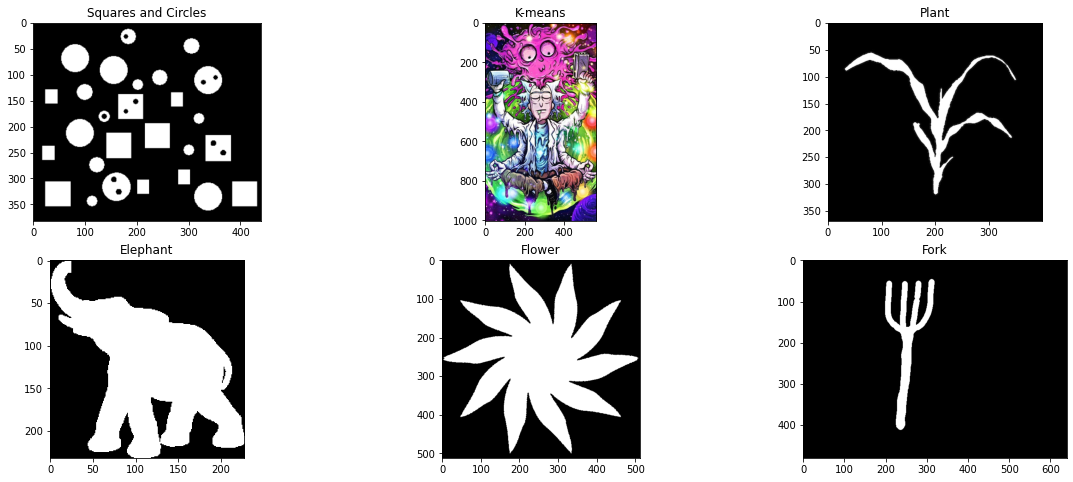

In [3]:
morphologic = cv2.imread('morfologica.PNG',0)
rick = cv2.imread('rick.jpg')
rick = cv2.cvtColor(rick, cv2.COLOR_BGR2RGB)
plant = cv2.imread('cropped_mask_image.jpg',0)
elephant = cv2.imread('elephant.png',0)
flower = cv2.imread('flower.png',0)
fork = cv2.imread('fork-20.png',0)

plt.figure(figsize=(20, 8), constrained_layout=False)
plt.subplot(231), plt.imshow(morphologic, cmap=plt.cm.gray), plt.title("Squares and Circles")
plt.subplot(232), plt.imshow(rick), plt.title("K-means")
plt.subplot(233), plt.imshow(plant, cmap=plt.cm.gray), plt.title("Plant")
plt.subplot(234), plt.imshow(elephant, cmap=plt.cm.gray), plt.title("Elephant")
plt.subplot(235), plt.imshow(flower, cmap=plt.cm.gray), plt.title("Flower")
plt.subplot(236), plt.imshow(fork, cmap=plt.cm.gray), plt.title("Fork")



# Item 1

> Para responder cada pergunta desse item, foram feitas algumas funções.

>> **Que fração dos pixels da imagem são brancos?**       
    Primeiramente é realizado a binarização da imagem, conta-se quantos pixels são brancos e se calcula a razão de pixels brancos.

In [4]:
morphologic_thresh = ((morphologic / 255).round() * 255).astype(np.uint8)
list_image = morphologic_thresh.ravel()
rows,columns = morphologic_thresh.shape
j = 0
for i in range(len(list_image)):
  if list_image[i] == 255:
    j += 1

ratio = j/(rows*columns)
print('White pixels ratio = {:.2f}'.format(ratio))

White pixels ratio = 0.22


>> **Quantos objetos a imagem possui?**           
   A função *connected_components*, conta quantos objetos têm, se utilizando da função do OpenCV [*connected_components*](https://docs.opencv.org/master/de/d01/samples_2cpp_2connected_components_8cpp-example.html), e logo após atribui um mapa de cores para cada objeto.    

In [5]:
[labeled_image, count, labels] = connected_components(morphologic_thresh[2:-1,2:-1])

objects number is: 27


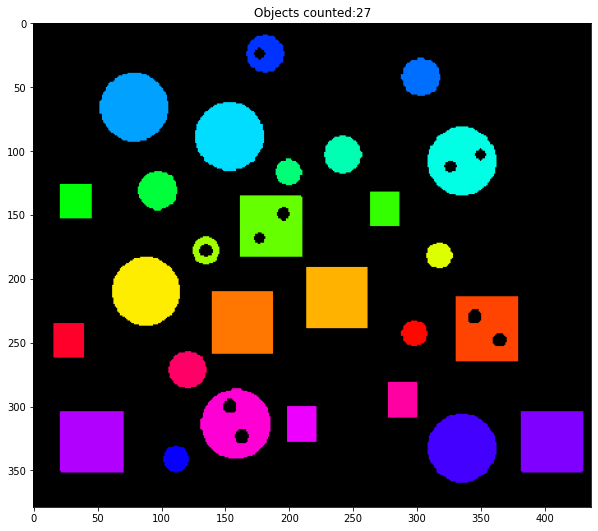

In [6]:
plt.figure(figsize=(10, 10))
plt.title('Objects counted:'+ str(count-1))
plt.imshow(labeled_image)
print('objects number is:', count-1)
plt.show()

>> **Quantos buracos há na imagem?**             
Para calcular quantos buracos há na imagem, com a função *dilate_erode*, que utiliza as funções do OpenCV [*erode* e *dilate*](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html), para preencher a maioria dos buracos da imagem original, subtrair o complemento da imagem original com o complemento do resultado da dilatação e erosão para retirar o fundo da imagem, aplicar o filtro de média para retirar os requícios da subtração e aplicar a função *connect_components* para calcular quantos buracos que a imagem possui.

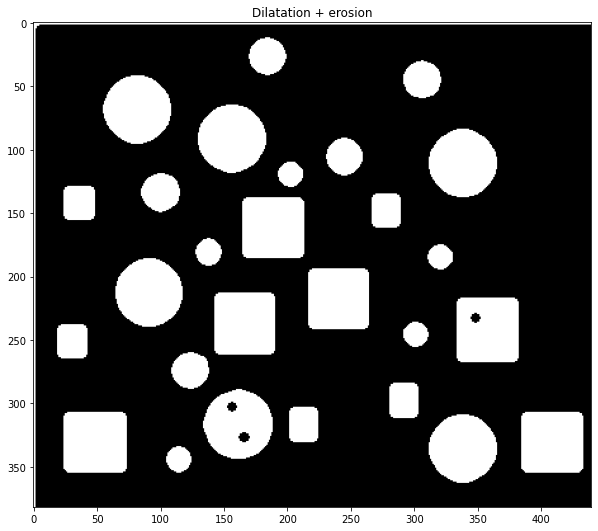

In [7]:
image_erode_all = dilate_erode(morphologic_thresh,8)
plt.figure(figsize=(10, 10))
plt.title('Dilatation + erosion')
plt.imshow(image_erode_all, cmap="gray", vmin=0, vmax=255)

Holes number is: 10


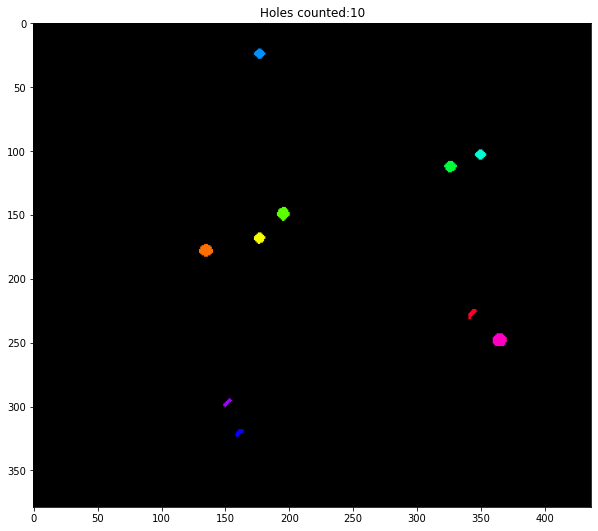

In [8]:
image = ~morphologic_thresh
image2 = ~image_erode_all
diff = image.astype(int) - image2.astype(int)
image3 = diff.astype(np.uint8)
median = cv2.medianBlur(image3,3)
median = cv2.medianBlur(median,3)
median = cv2.medianBlur(median,3)
median = cv2.medianBlur(median,3)
median = cv2.medianBlur(median,3)
median = cv2.medianBlur(median,3)
median = cv2.medianBlur(median,3)
[labeled_image_hole, count_hole, labels_hole] = connected_components(median[2:-1,2:-1])
plt.figure(figsize=(10, 10))
plt.title('Holes counted:'+ str(count_hole-1))
plt.imshow(labeled_image_hole)
print('Holes number is:', count_hole-1)
plt.show()

>> **Quantos objetos têm mais de um buraco?**             
Para esta pergunta, foi utilizado a lógica do [números de Euler](https://blogs.mathworks.com/steve/2014/10/02/lots-and-lots-of-euler-numbers/) para detecção de regiões desconectadas, ou buracos, na imagem. Neste método, conta -se o número de ocorrências desse padrão de vizinhança 2 por 2, ou invés de ser calculado por uma varredura de uma operação de vizinhança 2 por 2 puramente local. No link apresentado, a função é implementada em Matlab.

Number of objects without holes : 21
Number of objects with single hole : 2
Number of objects with two holes : 4


(<matplotlib.image.AxesImage at 0x7fc81f699a10>,
 Text(0.5, 1.0, 'Objects with holes'))

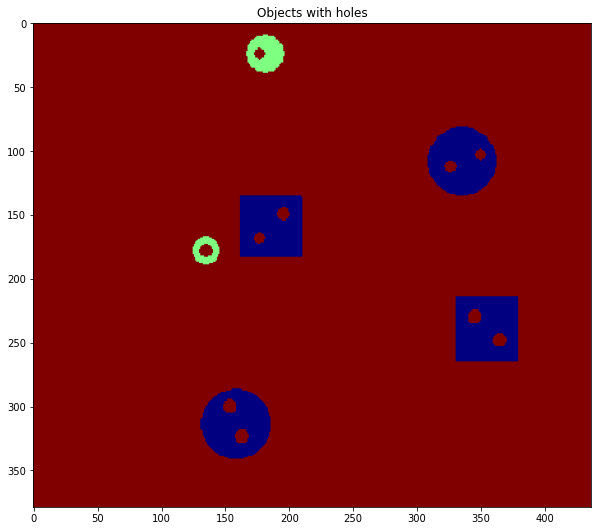

In [9]:
#Compute all the Euler numbers
euler = EulerNumbers(labels)

# All the regions with no holes will have an Euler number of 1. Regions with one hole
# will have an Euler number of 0. Two holes -> -1 etc. 

num_no_holes = np.sum(euler==1)
num_single_hole = np.sum(euler==0)
num_two_holes = np.sum(euler==-1)

print('Number of objects without holes : %d'%num_no_holes)
print('Number of objects with single hole : %d'%num_single_hole)
print('Number of objects with two holes : %d'%num_two_holes)

Euler2Numholes = lambda euler : abs(euler-1)
labels_hole_counts = np.zeros(labels.shape, dtype=np.int32)
for i in range(1, np.max(labels)):
    labels_hole_counts[labels == i] = Euler2Numholes(euler[i-1])

#Spread the small range to [0,255]
plot_holes = cv2.normalize(labels_hole_counts, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC1) 
#Note that this will break when there are more than 255 labels. The colormap only works with uint8.

#Colormap it
plot_holes = cv2.applyColorMap(plot_holes, cv2.COLORMAP_JET)

#cv2_imshow(plot_L)
plt.figure(figsize=(10, 10))
plt.imshow(plot_holes), plt.title('Objects with holes')

>> **Quantos quadrados e círculos a imagem possui?**
A função *circles* foi implementada para responder esta pergunta, ela utiliza a função [HoughCircles](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html) da OpenCV para contar a quantidade de círculos da imagem e faz uma abertura para suavizar os contornos para permitir uma melhor detecção, sabendo o número total de objetos que a imagem possui devido à primeira pergunta, foi subtraído o número total de objetos com o número de círculos para saber quantos quadrados há na imagem.

There are 16 circles
There are 11 squares


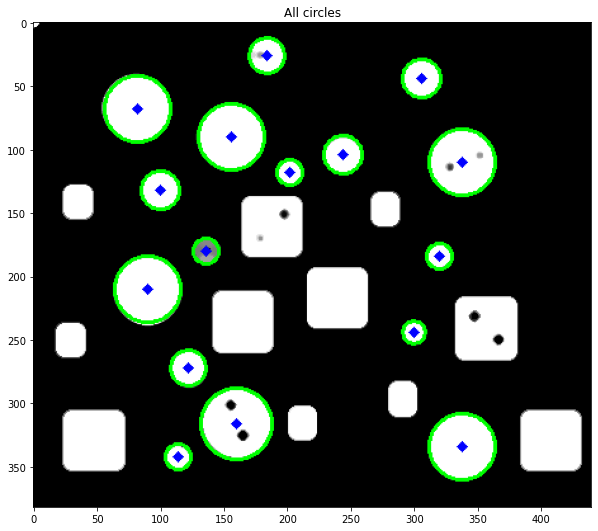

In [10]:
[circles_all, circles_vector] = circles(morphologic,7)
plt.figure(figsize=(10, 10))
plt.imshow(circles_all), plt.title('All circles')
squares = (count-1) - circles_vector.shape[1]
print('There are {} circles'.format(circles_vector.shape[1]))
print('There are {} squares'.format(squares))

>> **Identifique os objetos quadrados que possuem buracos e os objetos circulares que não possuem buracos?**                           
Por último, utilizando a imagem gerada somente com os objetos com buracos, foi subtraído os objetos com buracos da imagem original, e utilizado a função *circles* novamente para contar quantos círculos não tem buracos. Sabendo isso, é necessário somente subtrair o número total de círculos com os número de círculos sem furos, determinando o número de círcuos com furos. Como já foi determinado anteriormente o número de objetos com furos, subtrai a diferença do total objetos com buracos com o número de círculos com buracos.

In [11]:
morphologic_copy = morphologic[3:,3:]

There are 12 circles without holes
There are 2 squares with holes


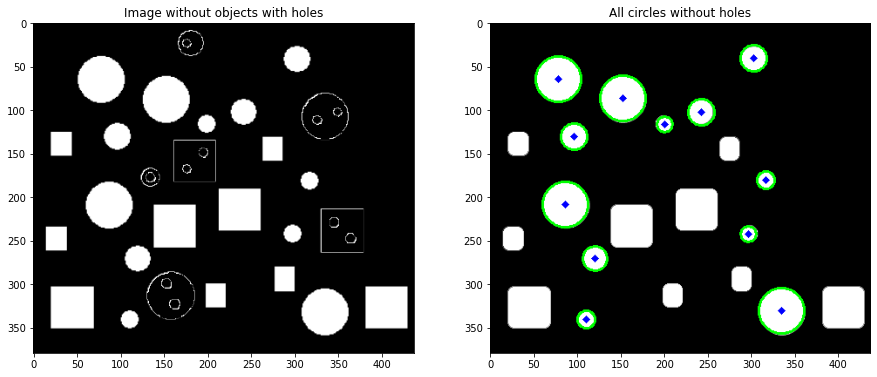

In [12]:
# convert to grayscale image with holes
gray = cv2.cvtColor(plot_holes,cv2.COLOR_BGR2GRAY)
# threshold
thresh = cv2.threshold(gray,30,255,cv2.THRESH_BINARY)[1]

morphologic_copy = (morphologic_copy.astype(int)-thresh.astype(int)).astype(np.uint8)
[circles_without_hole, circles_vector_hole] = circles(morphologic_copy,3)


plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(morphologic_copy, cmap="gray", vmin=0, vmax=255), plt.title('Image without objects with holes')
plt.subplot(122),plt.imshow(circles_without_hole), plt.title('All circles without holes')
squares_hole = (num_single_hole + num_two_holes) - (circles_vector.shape[1] - circles_vector_hole.shape[1])
print('There are {} circles without holes'.format(circles_vector_hole.shape[1]))
print('There are {} squares with holes'.format(squares_hole))

# Item 2


> O afinamento de um conjunto A por um elemento estruturante B, chamado $A \otimes B$, pode ser definido em termos da transformada *hit-or-miss*, como $A \otimes B = A -((A 	\ominus B_1) - (A \oplus \hat{B}_2)) $. Sabendo que $(A \ominus B_1)$ é a erosão do do conjunto A com um elemento estruturante $B_1$ e $(A \oplus \hat{B}_2)$ é o equivalente da dilatação do conjunto A pelo complemento do elemento estruturante $B_2$. 

> Devido a essa definição, a função *thinning*, utiliza uma lógica um pouco mais simples. Primeiramente é realizado uma erosão na imagem, com a função *erode* ($(A \ominus B_1)$), o resultado dessa erosão é dilatada com a função *dilate* ($(A \oplus \hat{B}_2)$), e é realizado a subtração da imagem original com o resultado da dilatação e a sua união, atualizando a imagem com o valor da erosão até não haver mais valores diferentes na imagem.

> A função *thinning_native_function* faz a mesma coisa da função *thinning*, porém com as funções *erode* e *dilate* da OpenCV.

> Ao final de ambas as funções implementadas é realizada a conectividade-m.

> A função [*thinning*](https://docs.opencv.org/master/df/d2d/group__ximgproc.html) da OpenCV também foi utilizada para comparação.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc81f4c27d0>,
 Text(0.5, 1.0, 'Fork'))

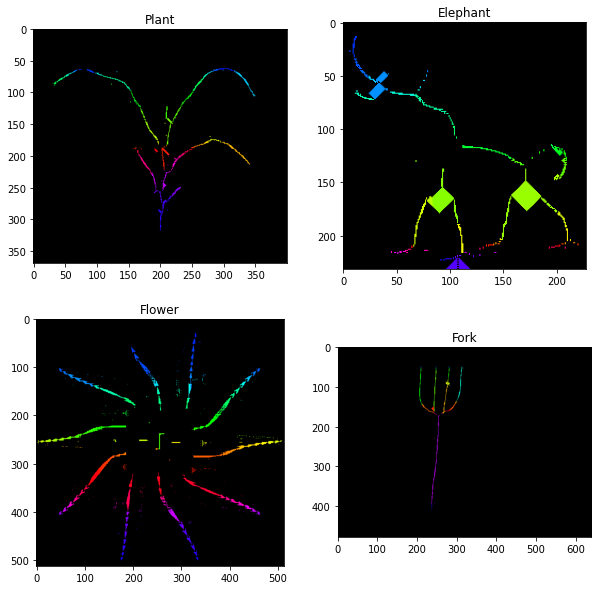

In [13]:
thinner_elephant = thinning(elephant, 3)
thinner_flower = thinning(flower, 7)
thinner_fork = thinning(fork, 3)
thinner_plant = thinning(plant, 3)

plt.figure(figsize=(10, 10), constrained_layout=False)
plt.subplot(221), plt.imshow(thinner_plant), plt.title("Plant")
plt.subplot(222), plt.imshow(thinner_elephant), plt.title("Elephant")
plt.subplot(223), plt.imshow(thinner_flower), plt.title("Flower")
plt.subplot(224), plt.imshow(thinner_fork), plt.title("Fork")

>> A lógica utilizado faz a esqueletização da imagem, porém o algoritmo de erosão e dilatação desenvolvidos não são suficientes para a imagem do elefante e da flor. Como ele é muito agressivo, a união dos elementos também e compromotida, apesar da seleção da adjacência-m ser possível e eficiente.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc81f660410>,
 Text(0.5, 1.0, 'Fork'))

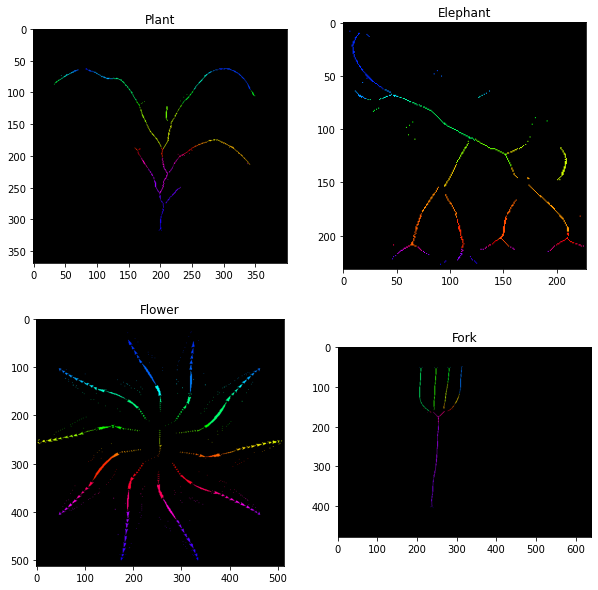

In [14]:
thinner_native_elephant = thinning_native_functions(elephant, 3)
thinner_native_flower = thinning_native_functions(flower, 7)
thinner_native_fork = thinning_native_functions(fork, 3)
thinner_native_plant = thinning_native_functions(plant, 3)

plt.figure(figsize=(10, 10), constrained_layout=False)
plt.subplot(221), plt.imshow(thinner_native_plant), plt.title("Plant")
plt.subplot(222), plt.imshow(thinner_native_elephant), plt.title("Elephant")
plt.subplot(223), plt.imshow(thinner_native_flower), plt.title("Flower")
plt.subplot(224), plt.imshow(thinner_native_fork), plt.title("Fork")

>> Utilizar as funções do OpenCV de erosão e dilatação, além do código ser bem mais rápido, melhoram os resultados para as imagens da flor e do elefante, apesar de ter o mesmo problema de ser bastante agressivo, impedindo uma união, porém permitindo uma adjacência. 

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc81f39cbd0>,
 Text(0.5, 1.0, 'Fork'))

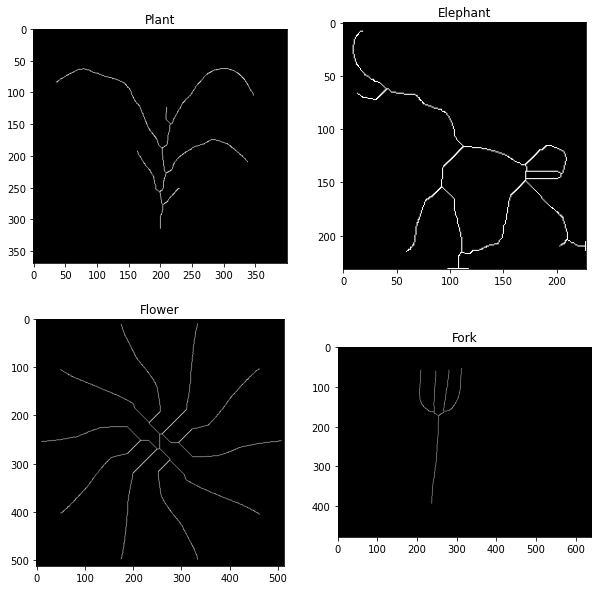

In [15]:
thinner_fork_cv = cv2.ximgproc.thinning(fork)
thinner_elephant_cv = cv2.ximgproc.thinning(elephant)
thinner_plant_cv = cv2.ximgproc.thinning(plant)
thinner_flower_cv = cv2.ximgproc.thinning(flower)

plt.figure(figsize=(10, 10), constrained_layout=False)
plt.subplot(221), plt.imshow(thinner_plant_cv, cmap=plt.cm.gray), plt.title("Plant")
plt.subplot(222), plt.imshow(thinner_elephant_cv, cmap=plt.cm.gray), plt.title("Elephant")
plt.subplot(223), plt.imshow(thinner_flower_cv, cmap=plt.cm.gray), plt.title("Flower")
plt.subplot(224), plt.imshow(thinner_fork_cv, cmap=plt.cm.gray), plt.title("Fork")

>> A função do OpenCV foi utilizada como gabarito para saber em qual resultado deveria se assemelhar. Mesmo com o algoritmo implementado sendo bastante limitado, ele consegue se assemelhar ao resultado esperado.

# Item 3

> O [*k-means*](https://stanford.edu/~cpiech/cs221/handouts/kmeans.html), como descrito no material de apoio, é um algoritmo de clusterização mais popular que encontra os melhores centróides sem rotulação, alternando entre atribuir pontos de dados a clusters com base nos centróides atuais e escolher centróides (pontos que são o centro de um cluster) com base na atribuição atual de pontos de dados a clusters. 

> A função do OpenCV [*kmeans*](https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html), foi utilizada em 2 funções para este item, uma é a *k_means* que faz a clusterização para toda a imagem e a função *k_means_each_channel* que a faz considerando cada canal da imagem. Logo ápos e calculado o índice de qualidade PNSR, função *calculate_psnr*, para cada resultado e comparado.

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc81f22cd10>,
 Text(0.5, 1.0, 'K = 256'))

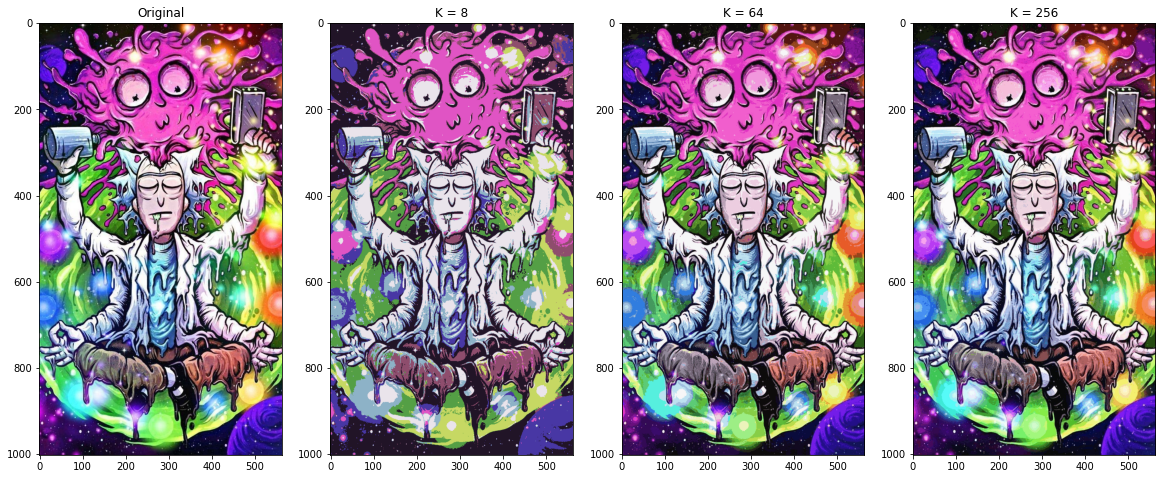

In [16]:
rick_out_8 = k_means(rick, 8)
rick_out_64 = k_means(rick, 64)
rick_out_256 = k_means(rick, 256)

plt.figure(figsize=(20, 10), constrained_layout=False)
plt.subplot(141),plt.imshow(rick), plt.title("Original")
plt.subplot(142),plt.imshow(rick_out_8), plt.title("K = 8")
plt.subplot(143),plt.imshow(rick_out_64), plt.title("K = 64")
plt.subplot(144),plt.imshow(rick_out_256), plt.title("K = 256")

In [17]:
k_8 = calculate_psnr(rick, rick_out_8)
print('The image PSNR with K = 8 is {:.2f}.'.format(k_8))
k_64 = calculate_psnr(rick, rick_out_64)
print('The image PSNR with K = 64 is {:.2f}.'.format(k_64))
k_256 = calculate_psnr(rick, rick_out_256)
print('The image PSNR with K = 256 is {:.2f}.'.format(k_256))

The image PSNR with K = 8 is 18.66.
The image PSNR with K = 64 is 25.03.
The image PSNR with K = 256 is 28.15.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc81f0c6450>,
 Text(0.5, 1.0, 'K = 256'))

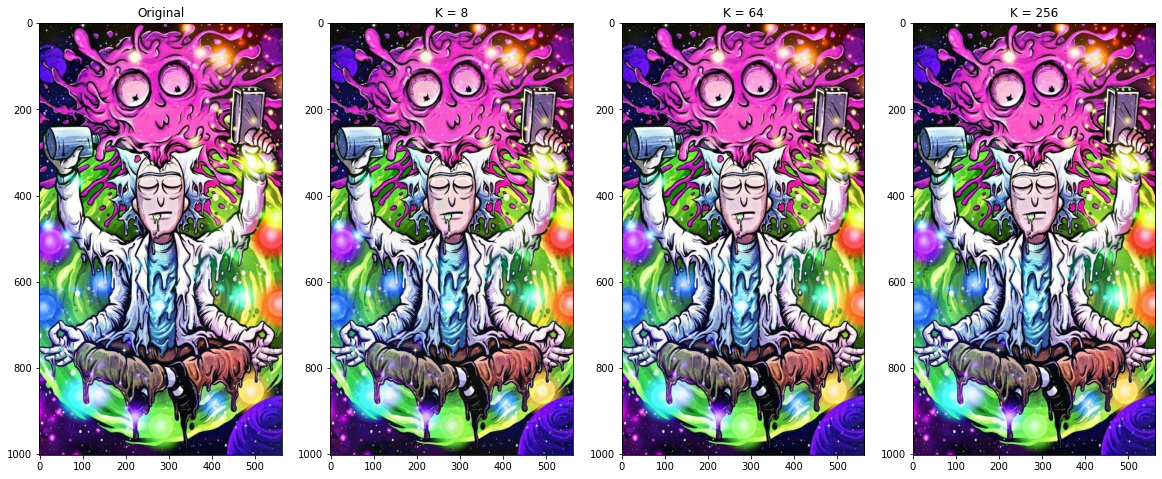

In [18]:
rick_channel_out_8 = k_means_each_channel(rick, 8)
rick_channel_out_64 = k_means_each_channel(rick, 64)
rick_channel_out_256 = k_means_each_channel(rick, 256)

plt.figure(figsize=(20, 10), constrained_layout=False)
plt.subplot(141),plt.imshow(rick), plt.title("Original")
plt.subplot(142),plt.imshow(rick_channel_out_8), plt.title("K = 8")
plt.subplot(143),plt.imshow(rick_channel_out_64), plt.title("K = 64")
plt.subplot(144),plt.imshow(rick_channel_out_256), plt.title("K = 256")

In [19]:
k_8_channel = calculate_psnr(rick, rick_channel_out_8)
print('The image PSNR with K = 8 for each channel is {:.2f}.'.format(k_8_channel))
k_64_channel = calculate_psnr(rick, rick_channel_out_64)
print('The image PSNR with K = 64 for each channel is {:.2f}.'.format(k_64_channel))
k_256_channel = calculate_psnr(rick, rick_channel_out_256)
print('The image PSNR with K = 256 for each channel is {:.2f}.'.format(k_256_channel))

The image PSNR with K = 8 for each channel is 28.87.
The image PSNR with K = 64 for each channel is 40.69.
The image PSNR with K = 256 for each channel is 47.09.


>> Utilizar o *k-means* para cada canal melhora a qualidade da imagem em relação ao resultado sem essa modificação em $35,37\%$, $38,49\%$ e $40,22\%$, respectivamente.

> Sabendo que uma imagem RGB, onde cada pixel tem 8 bits e 3 canais, uma imagem tem 24 bits, ou seja, $(2^8)^3 = 16777216$ cores.

> Para a imagem com $K = 8$, eu tenho 8 cores disponíveis para cada canal, ou seja, 24 cores. 

> Para a imagem com $K = 64$, eu tenho 64 cores disponíveis para cada canal, ou seja, 192 cores. 

> Para a imagem com $K = 256$, eu tenho 256 cores disponíveis para cada canal, ou seja, 768 cores. 

In [20]:
bits_8 = math.log2(24)
bits_64 = math.log2(192)
bits_256 = math.log2(768)

print('{} bits are enough in the image with K = 8.'.format(int(math.ceil(bits_8))))
print('{} bits are enough in the image with K = 64.'.format(int(math.ceil(bits_64))))
print('{} bits are enough in the image with K = 256.'.format(int(math.ceil(bits_256))))

5 bits are enough in the image with K = 8.
8 bits are enough in the image with K = 64.
10 bits are enough in the image with K = 256.
